# Simple Visualizations

Let's now use the tidied data to create some simple figures over the aggregated data. 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
# Load the dataset
df = pd.read_csv("tidied.csv")

# Comparing Shot Types and Goal Conversion for a Selected Season

We will use a stacked bar chart to show the distribution of different shot types (e.g., wrist shot, slapshot) across all teams for a chosen season (in our case, it is the 2016-17 season). Overlaying goals on top of shots in the same chart will allow us to easily compare the effectiveness of the different shot types.

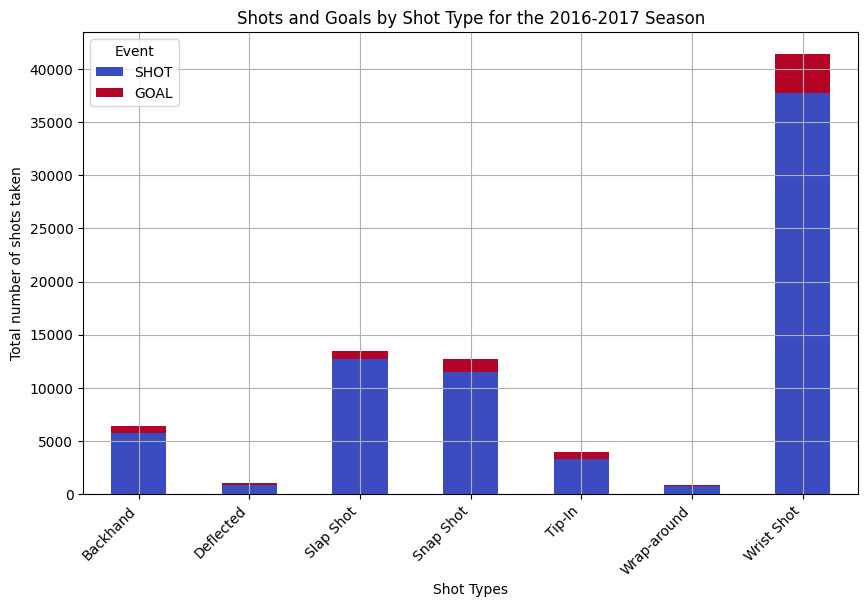

In [9]:
# Select a season
season = '2016-2017'

# Select only the rows of the chosen season
season_df = df[df['Season'] == season]

shot_data = season_df.groupby(['ShotType', 'Event']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = shot_data[['SHOT', 'GOAL']].plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))

plt.title(f'Shots and Goals by Shot Type for the {season} Season')
plt.xlabel('Shot Types')
plt.ylabel('Total number of shots taken')
plt.legend(title='Event')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Relationship Between Shot Distance and Goal Probability From the 2018-19 to 2020-21 Seasons

We will create line plots with shot distance on the x-axis and the chance of a goal (goal probability) on the y-axis for each season from 2018-19 to 2020-21. We will do one figure per season and one figure of all 3 seasons together in order to view the differences between the seasons more easily.

In [10]:
# Calculates the distance between a shot/goal and the net, rounded to the nearest number
# the column 'distance_to_goal' is added to the df
def distance(df: pd.DataFrame) -> pd.DataFrame:
    right_goal = [89, 0]
    left_goal = [-89, 0]

    distance_to_goal = np.zeros(df.shape[0])
    for i, row in df.iterrows():
    
        if row['RinkSide'] == 'right':
            distance_to_goal[i] = np.sqrt((row['XCoord'] - left_goal[0])**2 + (row['YCoord'] - left_goal[1])**2).round()
        
        elif row['RinkSide'] == 'left':
            distance_to_goal[i] = np.sqrt((row['XCoord'] - right_goal[0])**2 + (row['YCoord'] - right_goal[1])**2).round()
    
        else:
            distance_to_goal[i] = None  # some games didn't have the information for which side the team was defending

    # add the column with its values
    df['distance_to_goal'] = distance_to_goal
    return df


In [11]:
# Creates multiple graphs (one for each desired season) with one line plot
def plot_shot_goal_ratio(seasons: [str]):
    for i, season in enumerate(seasons):
        s = season.split("-")[0]  # assuming that the input will always be the format "yyyy-yyyy"
        season_df = df[df['GameID'].astype(str).str.startswith(s)]
        shot_season_df = season_df[season_df['GameID'].astype(str).str.startswith(s)]
        shot_season_df.reset_index(inplace=True)
        shot_season_df = distance(shot_season_df)
        result_df = shot_season_df.groupby('distance_to_goal').agg(
            shots=('Event', lambda x: (x == 'SHOT').sum()),
            goals=('Event', lambda x: (x == 'GOAL').sum())
        )
        # Calculate shot_goal_ratio
        result_df['shot_goal_ratio'] = result_df['goals'] / (result_df['shots'] + result_df['goals'])

        # Reset the index to get a clean DataFrame
        result_df.reset_index(inplace=True)

        # Plot the line graph
        plt.figure(figsize=(10, 6))
        plt.plot(result_df['distance_to_goal'], result_df['shot_goal_ratio'], label=s)
        plt.title(f'Shot-to-Goal Ratio vs. Distance to Goal for {season} season')
        plt.xlabel('Distance to Goal (in feet)')
        plt.ylabel('Shot-to-Goal Ratio')
        plt.grid(True)
        plt.show()


In [12]:
# Creates single graph with one line plot figure for each the desired season
def plot_shot_goal_ratio_full(seasons: [str]):
    # Graph for all seasons together
    plt.figure(figsize=(10, 6))

    # Create a list to store individual line plots
    line_plots = []

    for season in seasons:
        s = season.split("-")[0]  # assuming that the input will always be the format "yyyy-yyyy"
        season_df = df[df['GameID'].astype(str).str.startswith(s)]
        shot_season_df = season_df[season_df['GameID'].astype(str).str.startswith(s)]
        shot_season_df.reset_index(inplace=True)
        shot_season_df = distance(shot_season_df)
        result_df = shot_season_df.groupby('distance_to_goal').agg(
            shots=('Event', lambda x: (x == 'SHOT').sum()),
            goals=('Event', lambda x: (x == 'GOAL').sum())
        )
        # Calculate shot_goal_ratio
        result_df['shot_goal_ratio'] = result_df['goals'] / (result_df['shots'] + result_df['goals'])
    
        # Reset the index to get a clean DataFrame
        result_df.reset_index(inplace=True)
    
        # Create individual line plots for each season
        line_plot, = plt.plot(result_df['distance_to_goal'], result_df['shot_goal_ratio'], label=f'Season {season}')
        line_plots.append(line_plot)

    # Create a legend for the final combined graph
    plt.legend(handles=line_plots, loc='upper right')
    
    plt.title('Shot-to-Goal Ratio vs. Distance to Goal from the 2018-19 to 2020-21 seasons')
    plt.xlabel('Distance to Goal (in feet)')
    plt.ylabel('Shot-to-Goal Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()



In [13]:
# Select list of seasons to plot
seasons = ['2018-2019', '2019-2020', '2020-2021']

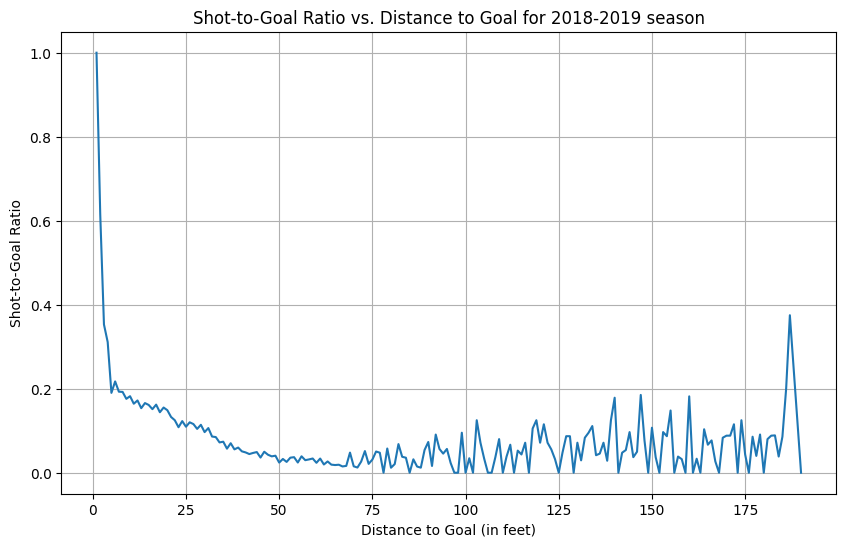

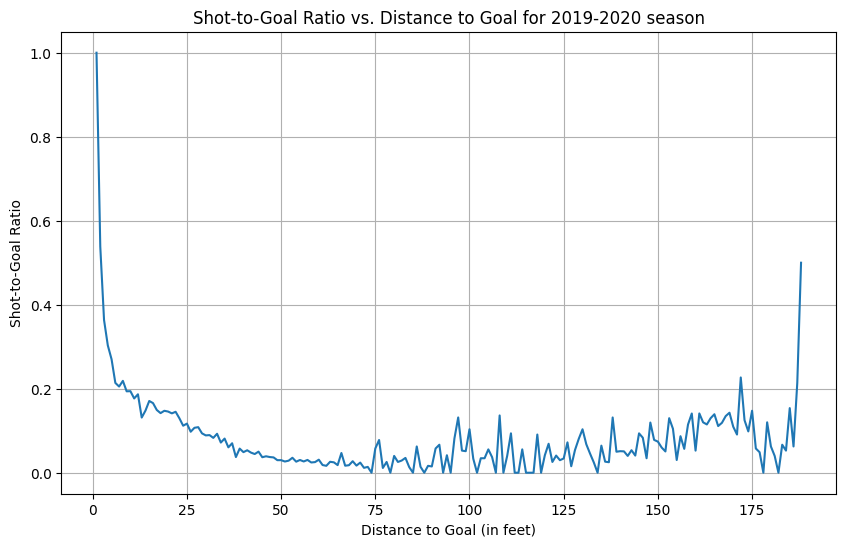

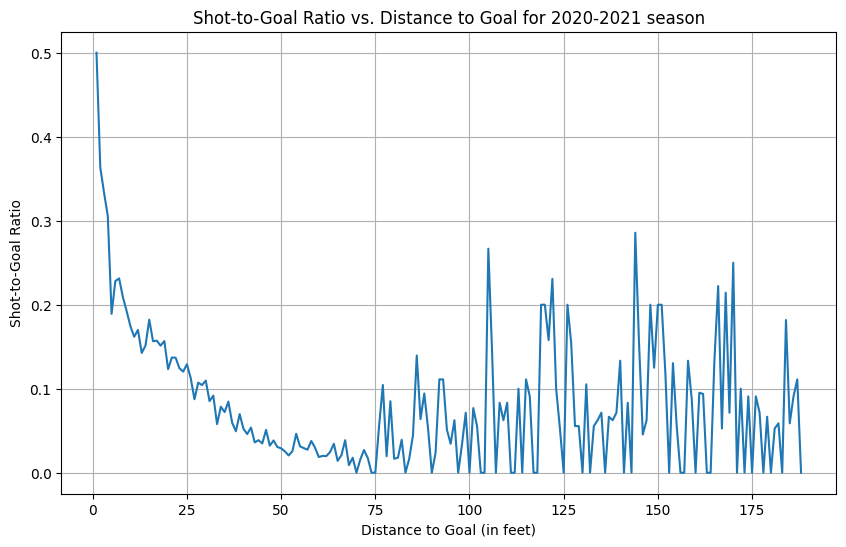

In [14]:
# plot the individual graphs
plot_shot_goal_ratio(seasons)

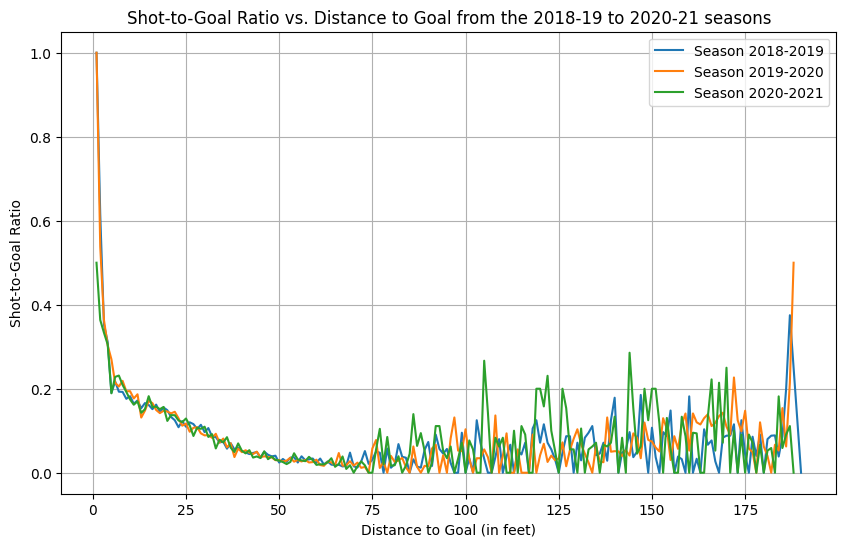

In [15]:
# plot the single graph with multiple line plots
plot_shot_goal_ratio_full(seasons)

# Goal Percentage by Shot Type and Distance for the 2016-17 Season

We will use a heatmap where the x-axis represents shot distance from the net, the y-axis represents different shot types (e.g., wrist shot, slapshot). The color intensity in each cell represents the goal percentage (# goals / # shots) for that combination of shot type and distance. Darker colors indicate higher goal percentages, while lighter colors indicate lower goal percentages.

In [84]:
df = pd.read_csv("tidied.csv")
df_copy = df.copy()
season = '2016-2017'

# Select only the rows of the chosen season
season_df = df_copy[df_copy['Season'] == season]
distance_df = distance(season_df)

# Count the occurrences of each unique value
value_counts = distance_df['distance_to_goal'].value_counts()
# print(value_counts, distance_df['distance_to_goal'].max())

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]#the reason to set bin like this is to average the number of events
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70']
categories = pd.cut(distance_df['distance_to_goal'], bins=bins, labels=labels, include_lowest=True)

# Create a new Series with the associated category labels
categorized_series = pd.Series(categories, name='Category')
distance_df['distance_category'] = categorized_series


# table = pd.pivot_table(distance_df, index=['distance_category', 'ShotType'],columns=['Event'], aggfunc="sum")
# table
grouped = distance_df.groupby(['distance_category', 'ShotType', 'Event']).size().unstack(fill_value=0)

# Reshape the data using pivot_table to get the desired format
result = grouped.pivot_table(index='ShotType', columns='distance_category', values=['GOAL', 'SHOT'], fill_value=0)
# print(categorized_series)
# categorized_series.value_counts()
# distance_df.head()
result

/var/folders/nc/rr6yw6w12bq773hvyyx6gm100000gn/T/ipykernel_30598/3939614266.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_goal'] = distance_to_goal
/var/folders/nc/rr6yw6w12bq773hvyyx6gm100000gn/T/ipykernel_30598/278940416.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_df['distance_category'] = categorized_series


Event             GOAL                                                       \
distance_category  0-5 5-10 10-15 15-20 20-25 25-30 30-35 35-40 40-45 45-50   
ShotType                                                                      
Backhand            32  308   192    55    21     8     4     5     1     3   
Deflected            8   84    49    28     6     5     2     4     3     1   
Slap Shot            5   19    26    35    57    70    98    95    87    84   
Snap Shot           13  113   143   172   169   160   140    84    50    27   
Tip-In              20  317   189   103    44    15     3     5     2     3   
Wrap-around         18   46     4     0     0     1     0     0     0     0   
Wrist Shot          74  726   710   473   394   324   224   167    96    77   

Event              ...  SHOT                                                  \
distance_category  ... 20-25 25-30 30-35 35-40 40-45 45-50 50-55 55-60 60-65   
ShotType           ...                                                         
Backhand           ...   554   346   247   172   109    73    45    39    10   
Deflected          ...    58    29    15     9     6     6     9    11     4   
Slap Shot          ...   256   475   746  1015  1288  1603  2393  2467  1213   
Snap Shot          ...  1075  1331  1400  1415  1174   972   779   742   372   
Tip-In             ...   224   103    33    11    11     8    18    15    20   
Wrap-around        ...     3     0     1     1     2     0     0     0     0   
Wrist Shot         ...  3287  3530  3654  3682  3388  2722  2448  2145  1270   

Event                    
distance_category 65-70  
ShotType                 
Backhand             18  
Deflected             8  
Slap Shot           290  
Snap Shot           115  
Tip-In               16  
Wrap-around           0  
Wrist Shot          501  

[7 rows x 28 columns]

In [85]:
percentage_df = result['GOAL'].div(result['SHOT']+result['GOAL']).fillna(0)
#percentage_df.replace([np.inf], 1, inplace=True)
percentage_df.iloc[5, 5] = 0
print(percentage_df)
# percentage_df_transposed = percentage_df.T
percentage_array = percentage_df.values#.reshape(14, 7)
percentage_df, percentage_array

distance_category       0-5      5-10     10-15     15-20     20-25     25-30  \
ShotType                                                                        
Backhand           0.363636  0.167119  0.107443  0.060241  0.036522  0.022599   
Deflected          0.727273  0.256098  0.161184  0.180645  0.093750  0.147059   
Slap Shot          0.384615  0.234568  0.200000  0.207101  0.182109  0.128440   
Snap Shot          0.265306  0.223320  0.200280  0.179728  0.135852  0.107311   
Tip-In             0.392157  0.224345  0.145273  0.167208  0.164179  0.127119   
Wrap-around        0.118421  0.080844  0.047619  0.000000  0.000000  0.000000   
Wrist Shot         0.331839  0.198795  0.170141  0.133465  0.107036  0.084069   

distance_category     30-35     35-40     40-45     45-50     50-55     55-60  \
ShotType                                                                        
Backhand           0.015936  0.028249  0.009091  0.039474  0.000000  0.000000   
Deflected          0.117647

(distance_category       0-5      5-10     10-15     15-20     20-25     25-30  \
 ShotType                                                                        
 Backhand           0.363636  0.167119  0.107443  0.060241  0.036522  0.022599   
 Deflected          0.727273  0.256098  0.161184  0.180645  0.093750  0.147059   
 Slap Shot          0.384615  0.234568  0.200000  0.207101  0.182109  0.128440   
 Snap Shot          0.265306  0.223320  0.200280  0.179728  0.135852  0.107311   
 Tip-In             0.392157  0.224345  0.145273  0.167208  0.164179  0.127119   
 Wrap-around        0.118421  0.080844  0.047619  0.000000  0.000000  0.000000   
 Wrist Shot         0.331839  0.198795  0.170141  0.133465  0.107036  0.084069   
 
 distance_category     30-35     35-40     40-45     45-50     50-55     55-60  \
 ShotType                                                                        
 Backhand           0.015936  0.028249  0.009091  0.039474  0.000000  0.000000   
 Deflected    

In [86]:
# percentage_array
for i in range(len(percentage_array)):
    for j in range(len(percentage_array[0])):
        if percentage_array[i][j] >1:
            print([i, j])

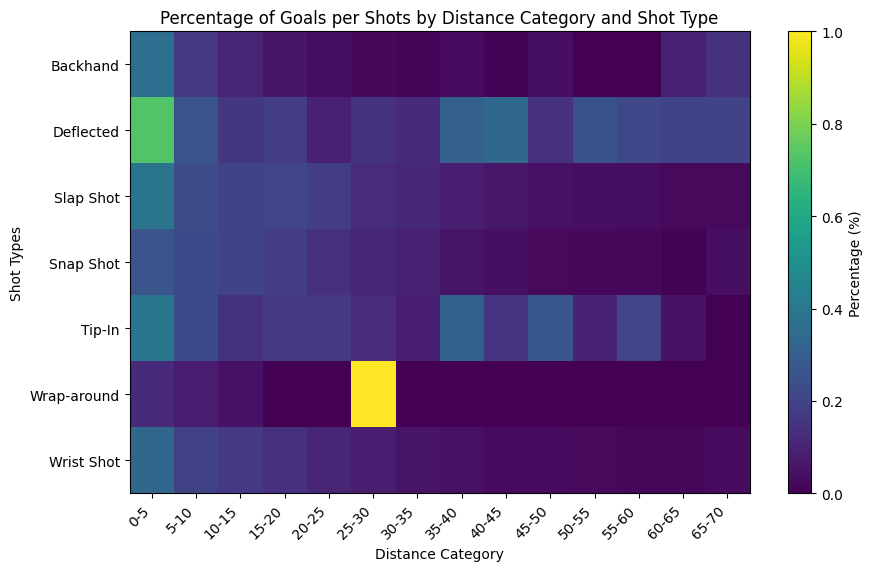

In [91]:
category_bins = ['Backhand', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Shot']
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70']

percentage_df = result['GOAL'].div(result['SHOT']+result['GOAL']).fillna(0)
#percentage_df.iloc[5, 5] = 0
# percentage_df_transposed = percentage_df.T
percentage_array = percentage_df.values
# percentage_df, percentage_array, percentage_array.shape


plt.figure(figsize=(10, 6))
plt.imshow(percentage_array, cmap='viridis', aspect='auto')

# Set labels and ticks
plt.xlabel('Distance Category')
plt.ylabel('Shot Types')

# Get the current axis
ax = plt.gca()

plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(category_bins)), category_bins)
plt.colorbar(label='Percentage (%)')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Display the plot
plt.title('Percentage of Goals per Shots by Distance Category and Shot Type')
plt.show()